In [1]:
import opendatasets as od

In [2]:
dataset_url = "https://www.kaggle.com/splcher/animefacedataset"

od.download(dataset_url)

Skipping, found downloaded files in ".\animefacedataset" (use force=True to force download)


In [3]:
import os

DATA_DIR = "./animefacedataset"

print(os.listdir(DATA_DIR))

['images']


In [4]:
print(os.listdir(DATA_DIR + "/images")[:10])

['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [6]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [7]:
transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

train_ds = ImageFolder(DATA_DIR, transform = transforms)

In [8]:
train_dl = DataLoader(train_ds,
                      batch_size = batch_size,
                      shuffle = True)

In [9]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_image(images, nmax = 64):
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1, 2, 0))

def show_batch(dl, nmax = 64):
    for images, _ in dl:
        show_image(images, nmax)
        break

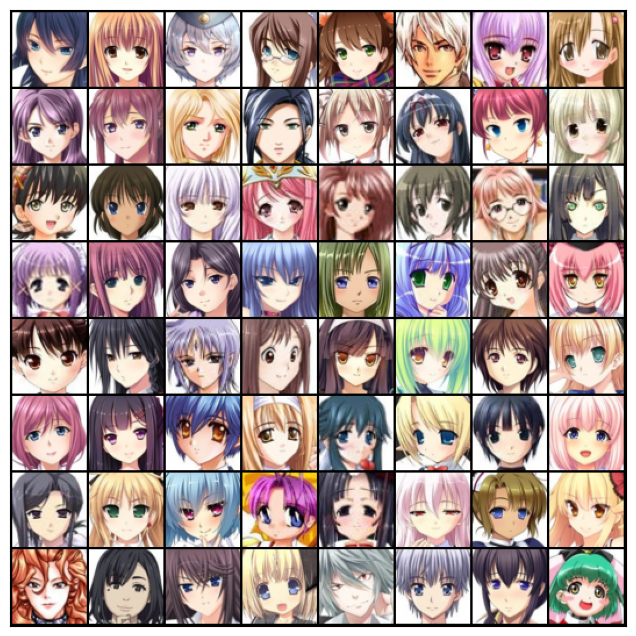

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

Discriminator Network

In [16]:
import torch.nn as nn

In [17]:
discriminator = nn.Sequential(
    # in: 3 X 64 X 64
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    # out: 64 X 32 X 32

    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    # out: 128 X 16 X 16

    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    # out: 256 X 8 X 8

    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    # out: 512 X 4 X 4

    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    # out: 1 X 1 X 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [18]:
discriminator = to_device(discriminator, device)

Generator Network

In [19]:
latent_size = 128

In [20]:
generator = nn.Sequential(
    # in: 128 X 1 X 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace = True),
    # out: 512 X 4 X 4

    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace = True),
    # out: 256 X 8 X 8

    nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace = True),
    # 128 X 16 X 16

    nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace = True),
    # 64 X 32 X 32

    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    # 3 X 64 X 64
)

torch.Size([128, 3, 64, 64])


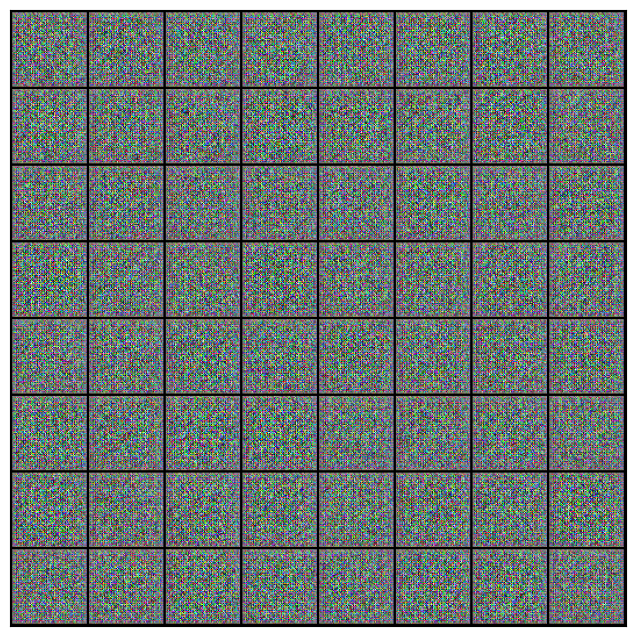

In [21]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_image(fake_images)

In [23]:
generator = to_device(generator, device)

In [24]:
import torch.nn.functional as F

In [26]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate Fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)

    # Pass fake images through the discriminator
    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss

    loss.backward()

    opt_d.step()

    return loss.item(), real_score, fake_score

Generator Training

In [27]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)

    # Trying to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()

    opt_g.step()

    return loss.item()

In [28]:
from torchvision.utils import save_image

In [29]:
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok = True)

In [30]:
def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
    print("Saving: ", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

In [31]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device = device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving:  generated-images-0000.png


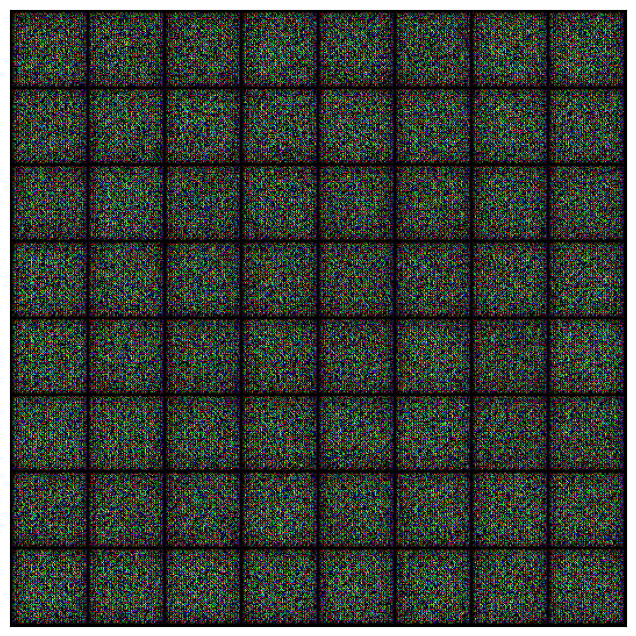

In [32]:
save_samples(0, fixed_latent)

In [33]:
from tqdm.notebook import tqdm

In [34]:
def fit(epochs, lr, start_idx = 1):
    torch.cuda.empty_cache()

    # Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create Optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))

    for epoch in epochs:
        for real_images, _ in tqdm(train_dl):

            # Train Discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_scores: {:.4f}, fake_scores: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score
        ))

        # Save generated Images
        save_samples(index = epoch+start_idx, latent_tensors = fixed_latent, show = True)

    return losses_g, losses_d, real_scores, fake_scores

In [35]:
lr = 0.0002
epochs = 10

In [ ]:
history = fit(epochs = epochs, lr = lr)